In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

In [2]:
# read the metadata csv
pbsummary_df = pd.read_csv('../metadata.csv', delimiter=';')
pbsummary_df = pbsummary_df.drop_duplicates()
pbsummary_df

pbsummary_aarau = pd.read_csv('../metadata_aarau.csv', delimiter=';')
# pbsummary_df = pd.concat([pbsummary_df, pbsummary_aarau], ignore_index=True)

pbsummary_df['subunit'].fillna(value='all', inplace=True)

In [3]:
# Get election id and vote type, so we know better to segragate approval and score votings
pbsummary_with_vote_type = pbsummary_df[['election_id', 'vote_type']]
print(pbsummary_with_vote_type.head())
print(pbsummary_with_vote_type['vote_type'].value_counts())

   election_id   vote_type
0            1  cumulative
1            2  cumulative
2            3  cumulative
3            4  cumulative
4            5  cumulative
vote_type
approval      613
cumulative    103
ordinal        95
Name: count, dtype: int64


In [4]:
# reading the projects CSV and loading to dataframe
pbprojects_df = pd.read_csv('../projects.csv', delimiter=';')
pbprojects_df.drop_duplicates(inplace=True)
print(pbprojects_df.shape)

pbprojects_aarau = pd.read_csv('../projects_aarau.csv', delimiter=';')
# pbprojects_df = pd.concat([pbprojects_df, pbprojects_aarau], ignore_index=True)

# merge the column vote_type into pbprojects_df
pbprojects_df = pd.merge(pbprojects_df, pbsummary_with_vote_type, on='election_id', how='inner')
print(pbprojects_df.shape)

pbprojects_df.head()


(19077, 21)
(19077, 22)


,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,...,englishName,target,total_budget,budget_percent,is_mes_winner,is_greedy_winner,is_phragmen_winner,latitude,longitude,vote_type
0,1,France,Toulouse,ARENES,2019,1,7000,1494,215,NaN,...,NaN,NaN,1000000.0,0.7,True,True,True,NaN,NaN,cumulative
1,1,France,Toulouse,BELLEFONTAINE MILAN,2019,2,35000,1494,26,NaN,...,NaN,NaN,1000000.0,3.5,False,False,False,NaN,NaN,cumulative
2,1,France,Toulouse,ARENES,2019,3,50000,1494,92,NaN,...,NaN,NaN,1000000.0,5.0,True,False,True,NaN,NaN,cumulative
3,1,France,Toulouse,PRADETTES,2019,4,390000,1494,471,NaN,...,NaN,NaN,1000000.0,39.0,False,True,False,NaN,NaN,cumulative
4,1,France,Toulouse,NEGRENEYS,2019,5,168000,1494,205,NaN,...,NaN,NaN,1000000.0,16.8,True,True,True,NaN,NaN,cumulative


In [5]:
# Check for projects where cost of a given project is zero

print("Projects with zero costs: ", pbprojects_df[pbprojects_df['cost'] == 0])

# Currently returns a single project ID which has been commented as been removed by City Council
invalid_projects = pbprojects_df[pbprojects_df['cost'] == 0][['project_id','election_id']]
print(invalid_projects)

# Excluding that single project id by checking with particular election id and project id
valid_pbprojects_df = pbprojects_df[~(pbprojects_df['project_id'].isin(invalid_projects['project_id']) & (pbprojects_df['election_id'].isin(invalid_projects['election_id'])))]
print(pbprojects_df.shape)
print(valid_pbprojects_df.shape)

Projects with zero costs:       election_id country    unit           subunit  instance project_id  cost  \
893           72  Poland  Gdynia  Grabówek | large      2020          5     0   

     project_voters_count  votes  score  ... englishName target  total_budget  \
893                  1511     18    NaN  ...         NaN    NaN      295110.0   

    budget_percent  is_mes_winner  is_greedy_winner  is_phragmen_winner  \
893            0.0           True              True                True   

     latitude  longitude  vote_type  
893       NaN        NaN   approval  

[1 rows x 22 columns]
    project_id  election_id
893          5           72
(19077, 22)
(19076, 22)


In [6]:
# There are citywide elections (unit-level); i.e. subunit is na, for such records fill na columns with values for subunit as all
valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)

# Cross checking for projects where by we have filled with subunit equalling the value 'all'
print(valid_pbprojects_df[valid_pbprojects_df['subunit'] == 'all'].shape)

(1928, 22)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_14340\2651770478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_pbprojects_df['subunit'].fillna(value='all', inplace=True)


In [7]:
for col in valid_pbprojects_df.columns:
    print(col)

election_id
country
unit
subunit
instance
project_id
cost
project_voters_count
votes
score
category
name
englishName
target
total_budget
budget_percent
is_mes_winner
is_greedy_winner
is_phragmen_winner
latitude
longitude
vote_type


In [8]:
valid_pbprojects_df['category'].value_counts()

category
urban greenery,public space,environmental protection    631
culture,education                                       623
education,culture                                       604
education                                               540
public transit and roads                                411
                                                       ... 
public space,public transit and roads,health              1
culture,sport,urban greenery                              1
education,public transit and roads,health                 1
sport,culture,urban greenery                              1
health,sport,public transit and roads                     1
Name: count, Length: 344, dtype: int64

In [9]:
aarau_election_id = valid_pbprojects_df[valid_pbprojects_df['unit'] == 'Aarau'].groupby(['election_id']).first().reset_index()['election_id']
green_budget_election_id = valid_pbprojects_df[valid_pbprojects_df['unit'] == 'Wieliczka'].groupby(['election_id']).first().reset_index()['election_id']

In [10]:
print("Distinct election IDs are: ", valid_pbprojects_df['election_id'].nunique())
valid_pbprojects_df_grouped_election = valid_pbprojects_df.groupby(['election_id','is_mes_winner'])['cost'].agg(['sum']).reset_index()
print(valid_pbprojects_df_grouped_election.head())
print(valid_pbprojects_df_grouped_election.shape)
print("Unique election IDs after grouping total costs: ", valid_pbprojects_df_grouped_election['election_id'].nunique())
mes_winners_grouped_project_count = valid_pbprojects_df_grouped_election[valid_pbprojects_df_grouped_election['is_mes_winner'] == True]
print(mes_winners_grouped_project_count.shape)

Distinct election IDs are:  811
   election_id  is_mes_winner       sum
0            1          False   1455000
1            1           True    997000
2            2          False  23588713
3            2           True   2350560
4            3          False    804294
(1561, 3)
Unique election IDs after grouping total costs:  811
(811, 3)


In [11]:
# setting additional column for used budget with MES aggregation
print(valid_pbprojects_df.shape)

elections_with_mes_winners = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True]
elections_with_greedy_winners = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner'] == True]
print("Elections with MES winners: ", elections_with_mes_winners['election_id'].nunique())
print("Elections with Greedy Winners: ", elections_with_greedy_winners['election_id'].nunique())

# Getting the total budget usage for MES winning projects of each election_id (grouped) and adding a new column to denote that value
valid_pb_projects_mes_budget_usage = valid_pbprojects_df[valid_pbprojects_df['is_mes_winner'] == True].groupby(['election_id'])['cost'].sum().reset_index()
valid_pb_projects_mes_budget_usage.rename(columns={'cost': 'mes_total_budget_usage'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_mes_budget_usage, on='election_id', how='inner')
valid_pbprojects_df['mes_budget_usage_percent'] = round((valid_pbprojects_df['mes_total_budget_usage'] / valid_pbprojects_df['total_budget'] * 100),3)
print(valid_pbprojects_df.shape)

# Getting the total budget usage for utilitarian greedy winning projects of each election_id (grouped) and adding a new column to denote that value
valid_pb_projects_greedy_budget_usage = valid_pbprojects_df[valid_pbprojects_df['is_greedy_winner']].groupby(['election_id'])['cost'].sum().reset_index()
valid_pb_projects_greedy_budget_usage.rename(columns={'cost': 'greedy_total_budget_usage'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(valid_pb_projects_greedy_budget_usage, on='election_id', how='inner')
valid_pbprojects_df['greedy_budget_usage_percent'] = round((valid_pbprojects_df['greedy_total_budget_usage'] / valid_pbprojects_df['total_budget'] * 100),3)
print(valid_pbprojects_df.shape)

(19076, 22)
Elections with MES winners:  811
Elections with Greedy Winners:  811
(19076, 24)
(19076, 26)


In [12]:
valid_pbprojects_df['category'].value_counts()

# Checking to see if there are empty values for category in the entire project dataset
na_category_count = valid_pbprojects_df['category'].isna().sum()
print("Empty category values for PB projects are: ", na_category_count)

# Fill such empty values of category with the label uncategorized, so that it can aid in further data preprocessing
valid_pbprojects_df['category'].fillna('uncategorized', inplace=True)


print("Emtpy category values after filling na: ", valid_pbprojects_df['category'].isna().sum())
print("`uncategorized` category count for valid pb projects: ", valid_pbprojects_df[valid_pbprojects_df['category'] == 'uncategorized'].shape[0])

Empty category values for PB projects are:  8182
Emtpy category values after filling na:  0
`uncategorized` category count for valid pb projects:  8182


In [13]:
def trimCategoryText(category_text):
    return category_text.split(',')[0]

valid_pbprojects_df['major_category'] = valid_pbprojects_df['category'].apply(trimCategoryText)
valid_pbprojects_df['major_category'].nunique()

print("Empty major category: ", valid_pbprojects_df['major_category'].isna().sum())
print("---------------------------------------------------------------")
print("Counts for each major category: \n", valid_pbprojects_df['major_category'].value_counts())
print("---------------------------------------------------------------")
print("Major categories sum: ", valid_pbprojects_df['major_category'].value_counts().sum())

Empty major category:  0
---------------------------------------------------------------
Counts for each major category: 
 major_category
uncategorized               8182
education                   2434
public space                2058
urban greenery              1484
sport                       1293
public transit and roads    1239
culture                     1123
environmental protection     716
welfare                      310
health                       237
Name: count, dtype: int64
---------------------------------------------------------------
Major categories sum:  19076


In [14]:
# Split the Categories column and create a set of unique categories
categories_set = set(category.strip() for categories in valid_pbprojects_df['category'] for category in categories.split(','))
print(categories_set)

# Create new columns with default value 0
for category in categories_set:
    valid_pbprojects_df[f'category_{category}'] = 0

# Iterate through rows and update the new columns
for index, row in valid_pbprojects_df.iterrows():
    categories = row['category'].split(',')
    for category in categories:
        valid_pbprojects_df.at[index, f'category_{category.strip()}'] = 1
    
    if(len(categories) == 1 and (categories[0] == 'uncategorized')):
        valid_pbprojects_df.at[index, 'category_labels_count'] = 0
    else:
        valid_pbprojects_df.at[index, 'category_labels_count'] = int(len(categories))

valid_pbprojects_df.tail()

{'culture', 'education', 'uncategorized', 'urban greenery', 'welfare', 'public space', 'environmental protection', 'public transit and roads', 'sport', 'health'}


,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,...,category_education,category_uncategorized,category_urban greenery,category_welfare,category_public space,category_environmental protection,category_public transit and roads,category_sport,category_health,category_labels_count
19071,809,Poland,Zabrze,Zaborze Północ,2021,P0039,310000,1280,823,NaN,...,0,1,0,0,0,0,0,0,0,0.0
19072,809,Poland,Zabrze,Zaborze Północ,2021,P0019,310000,1280,367,NaN,...,0,1,0,0,0,0,0,0,0,0.0
19073,809,Poland,Zabrze,Zaborze Północ,2021,P0069,309459,1280,90,NaN,...,0,1,0,0,0,0,0,0,0,0.0
19074,810,Poland,Zabrze,Zaborze Południe,2021,P0020,155000,112,112,NaN,...,0,1,0,0,0,0,0,0,0,0.0
19075,811,Poland,Zabrze,Zandka,2021,P0058,155000,105,105,NaN,...,0,1,0,0,0,0,0,0,0,0.0


In [15]:
# remove instances for which there is no project categories
valid_pbprojects_df = valid_pbprojects_df[valid_pbprojects_df['category'] != 'uncategorized']
print(valid_pbprojects_df.shape)

(10894, 38)


In [16]:
instance_grouped_total_projects_cost_df = valid_pbprojects_df.groupby(['election_id'])['cost'].sum().reset_index()
instance_grouped_total_projects_cost_df.rename(columns={'cost': 'total_projects_cost'}, inplace=True)
valid_pbprojects_df = valid_pbprojects_df.merge(instance_grouped_total_projects_cost_df, on='election_id', how='inner')

In [17]:
valid_pbprojects_df.rename(columns={
    'category_education': 'education', 
    'category_public transit and roads': 'public_transit_and_roads', 
    'category_health': 'health', 
    'category_welfare': 'welfare', 
    'category_uncategorized':'uncategorized', 
    'category_public space': 'public_space', 
    'category_urban greenery': 'urban_greenery', 
    'category_culture': 'culture', 
    'category_sport': 'sport', 
    'category_environmental protection': 'env_protection', 
    'category_labels_count': 'total_tags' 
}, inplace=True)

valid_pbprojects_df

,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,...,uncategorized,urban_greenery,welfare,public_space,env_protection,public_transit_and_roads,sport,health,total_tags,total_projects_cost
0,332,Poland,Warszawa,Aleksandrów,2017,261,80000,422,172,NaN,...,0,0,0,1,0,1,0,0,2.0,287217
1,332,Poland,Warszawa,Aleksandrów,2017,1112,99267,422,140,NaN,...,0,0,0,0,0,1,0,0,1.0,287217
2,332,Poland,Warszawa,Aleksandrów,2017,720,30000,422,118,NaN,...,0,0,0,1,0,0,0,0,3.0,287217
3,332,Poland,Warszawa,Aleksandrów,2017,1206,9200,422,99,NaN,...,0,0,0,0,0,0,1,0,2.0,287217
4,332,Poland,Warszawa,Aleksandrów,2017,2592,68750,422,86,NaN,...,0,0,0,0,0,1,0,0,1.0,287217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10889,676,Poland,Wieliczka,Green Budget,2023,69,8300,6586,101,NaN,...,0,1,1,0,1,0,0,0,3.0,3147413
10890,676,Poland,Wieliczka,Green Budget,2023,38,100000,6586,91,NaN,...,0,0,1,1,1,0,0,0,3.0,3147413
10891,676,Poland,Wieliczka,Green Budget,2023,48,50000,6586,84,NaN,...,0,0,1,1,0,0,0,0,2.0,3147413
10892,676,Poland,Wieliczka,Green Budget,2023,59,50000,6586,81,NaN,...,0,0,1,0,0,0,0,0,2.0,3147413


In [18]:
# total number of projects per election
election_projects_count = valid_pbprojects_df.groupby('election_id')['project_id'].count().reset_index()
election_projects_count.rename(columns={'project_id': 'num_projects'}, inplace=True)

valid_pbprojects_df = valid_pbprojects_df.merge(election_projects_count, on='election_id', how='inner')
valid_pbprojects_df


,election_id,country,unit,subunit,instance,project_id,cost,project_voters_count,votes,score,...,urban_greenery,welfare,public_space,env_protection,public_transit_and_roads,sport,health,total_tags,total_projects_cost,num_projects
0,332,Poland,Warszawa,Aleksandrów,2017,261,80000,422,172,NaN,...,0,0,1,0,1,0,0,2.0,287217,5
1,332,Poland,Warszawa,Aleksandrów,2017,1112,99267,422,140,NaN,...,0,0,0,0,1,0,0,1.0,287217,5
2,332,Poland,Warszawa,Aleksandrów,2017,720,30000,422,118,NaN,...,0,0,1,0,0,0,0,3.0,287217,5
3,332,Poland,Warszawa,Aleksandrów,2017,1206,9200,422,99,NaN,...,0,0,0,0,0,1,0,2.0,287217,5
4,332,Poland,Warszawa,Aleksandrów,2017,2592,68750,422,86,NaN,...,0,0,0,0,1,0,0,1.0,287217,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10889,676,Poland,Wieliczka,Green Budget,2023,69,8300,6586,101,NaN,...,1,1,0,1,0,0,0,3.0,3147413,64
10890,676,Poland,Wieliczka,Green Budget,2023,38,100000,6586,91,NaN,...,0,1,1,1,0,0,0,3.0,3147413,64
10891,676,Poland,Wieliczka,Green Budget,2023,48,50000,6586,84,NaN,...,0,1,1,0,0,0,0,2.0,3147413,64
10892,676,Poland,Wieliczka,Green Budget,2023,59,50000,6586,81,NaN,...,0,1,0,0,0,0,0,2.0,3147413,64


In [19]:
# number of projects per election with respective tags
categories_set = ['education', 'health', 'welfare', 'culture', 'sport', 'public_space', 'public_transit_and_roads', 'urban_greenery', 'env_protection']

for category in categories_set:
    category_projects_in_election = valid_pbprojects_df[valid_pbprojects_df[category] == 1].groupby('election_id')['project_id'].count().reset_index()
    category_projects_in_election.rename(columns={'project_id': f'{category}_project_counts'}, inplace=True)

    valid_pbprojects_df = valid_pbprojects_df.merge(category_projects_in_election, how='left', on='election_id')
    valid_pbprojects_df[f'{category}_project_counts'].fillna(0, inplace=True)


# cost of projects per election with respective tags
for category in categories_set:
    category_projects_cost_per_election = valid_pbprojects_df[valid_pbprojects_df[category] == 1].groupby('election_id')['cost'].sum().reset_index()
    category_projects_cost_per_election.rename(columns={'cost': f'{category}_total_cost'}, inplace=True)

    valid_pbprojects_df = valid_pbprojects_df.merge(category_projects_cost_per_election, how='left', on='election_id')
    valid_pbprojects_df[f'{category}_total_cost'].fillna(0, inplace=True)

# popularity in terms of votes received by project impact areas with respect to each individual election
for category in categories_set:
    category_projects_popularity_per_election = valid_pbprojects_df[valid_pbprojects_df[category] == 1].groupby('election_id')['votes'].sum().reset_index()
    category_projects_popularity_per_election.rename(columns={'votes': f'{category}_total_votes'}, inplace=True)

    valid_pbprojects_df = valid_pbprojects_df.merge(category_projects_popularity_per_election, how='left', on='election_id')
    valid_pbprojects_df[f'{category}_total_votes'].fillna(0, inplace=True)

# initialize total approval as 0 for each project/instance; to be updated in the following loop
valid_pbprojects_df['total_selections'] = 0

for category in categories_set:
    valid_pbprojects_df['total_selections'] += valid_pbprojects_df[f'{category}_total_votes']


# fraction/share of projects w.r.t to total projects
for category in categories_set:
    valid_pbprojects_df[f'{category}_project_count_share'] = 1 * valid_pbprojects_df[f'{category}_project_counts'] / valid_pbprojects_df['num_projects']
    valid_pbprojects_df[f'{category}_project_cost_share'] = 1 * valid_pbprojects_df[f'{category}_total_cost'] / valid_pbprojects_df['total_projects_cost']
    valid_pbprojects_df[f'{category}_popularity_share'] = 1 * valid_pbprojects_df[f'{category}_total_votes'] / valid_pbprojects_df['total_selections']
    valid_pbprojects_df[f'{category}_budget_share'] = 1 * valid_pbprojects_df[f'{category}_total_cost'] / valid_pbprojects_df['total_budget']

In [20]:
# fetch relevant dataset only
cols_to_select = ['election_id']

for category in categories_set:
    cols_to_select.append(f'{category}_project_count_share')
    cols_to_select.append(f'{category}_project_cost_share')
    cols_to_select.append(f'{category}_popularity_share')

impact_area_res = valid_pbprojects_df[cols_to_select]
print(impact_area_res.shape)

impact_area_res.drop_duplicates(inplace=True)
print(impact_area_res.shape)


(10894, 28)
(345, 28)


C:\Users\scsmah\AppData\Local\Temp\ipykernel_14340\1696754977.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  impact_area_res.drop_duplicates(inplace=True)


In [21]:
impact_area_agg = impact_area_res.describe()

impact_area_agg

,election_id,education_project_count_share,education_project_cost_share,education_popularity_share,health_project_count_share,health_project_cost_share,health_popularity_share,welfare_project_count_share,welfare_project_cost_share,welfare_popularity_share,...,public_space_popularity_share,public_transit_and_roads_project_count_share,public_transit_and_roads_project_cost_share,public_transit_and_roads_popularity_share,urban_greenery_project_count_share,urban_greenery_project_cost_share,urban_greenery_popularity_share,env_protection_project_count_share,env_protection_project_cost_share,env_protection_popularity_share
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,...,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,504.000000,0.395575,0.292815,0.159384,0.190065,0.201629,0.083988,0.053449,0.041919,0.019603,...,0.228266,0.211600,0.287615,0.098265,0.204704,0.244356,0.105023,0.158332,0.154330,0.082792
std,99.737155,0.189218,0.202107,0.087907,0.164781,0.203834,0.074214,0.069052,0.067265,0.027398,...,0.094076,0.160734,0.204048,0.081483,0.151423,0.198720,0.072082,0.129579,0.152435,0.062667
min,332.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,418.000000,0.269231,0.141601,0.097922,0.056075,0.029622,0.016609,0.000000,0.000000,0.000000,...,0.178725,0.101124,0.141704,0.052128,0.076923,0.067579,0.048246,0.058824,0.020606,0.036511
50%,504.000000,0.393939,0.260883,0.152103,0.176471,0.138674,0.077229,0.034483,0.011219,0.009388,...,0.232645,0.181818,0.258829,0.083556,0.187500,0.226426,0.102605,0.142857,0.128340,0.080242
75%,590.000000,0.533333,0.400746,0.219318,0.285714,0.330853,0.124575,0.085714,0.064301,0.030173,...,0.284608,0.285714,0.391942,0.128089,0.320896,0.379815,0.159151,0.236641,0.237184,0.124147
max,676.000000,1.000000,1.000000,0.466667,1.000000,1.000000,0.500000,0.468750,0.540623,0.225366,...,0.887160,1.000000,1.000000,0.569554,1.000000,1.000000,0.333333,1.000000,1.000000,0.333333


In [22]:
impact_area_agg

,election_id,education_project_count_share,education_project_cost_share,education_popularity_share,health_project_count_share,health_project_cost_share,health_popularity_share,welfare_project_count_share,welfare_project_cost_share,welfare_popularity_share,...,public_space_popularity_share,public_transit_and_roads_project_count_share,public_transit_and_roads_project_cost_share,public_transit_and_roads_popularity_share,urban_greenery_project_count_share,urban_greenery_project_cost_share,urban_greenery_popularity_share,env_protection_project_count_share,env_protection_project_cost_share,env_protection_popularity_share
count,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,...,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000,345.000000
mean,504.000000,0.395575,0.292815,0.159384,0.190065,0.201629,0.083988,0.053449,0.041919,0.019603,...,0.228266,0.211600,0.287615,0.098265,0.204704,0.244356,0.105023,0.158332,0.154330,0.082792
std,99.737155,0.189218,0.202107,0.087907,0.164781,0.203834,0.074214,0.069052,0.067265,0.027398,...,0.094076,0.160734,0.204048,0.081483,0.151423,0.198720,0.072082,0.129579,0.152435,0.062667
min,332.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,418.000000,0.269231,0.141601,0.097922,0.056075,0.029622,0.016609,0.000000,0.000000,0.000000,...,0.178725,0.101124,0.141704,0.052128,0.076923,0.067579,0.048246,0.058824,0.020606,0.036511
50%,504.000000,0.393939,0.260883,0.152103,0.176471,0.138674,0.077229,0.034483,0.011219,0.009388,...,0.232645,0.181818,0.258829,0.083556,0.187500,0.226426,0.102605,0.142857,0.128340,0.080242
75%,590.000000,0.533333,0.400746,0.219318,0.285714,0.330853,0.124575,0.085714,0.064301,0.030173,...,0.284608,0.285714,0.391942,0.128089,0.320896,0.379815,0.159151,0.236641,0.237184,0.124147
max,676.000000,1.000000,1.000000,0.466667,1.000000,1.000000,0.500000,0.468750,0.540623,0.225366,...,0.887160,1.000000,1.000000,0.569554,1.000000,1.000000,0.333333,1.000000,1.000000,0.333333


In [23]:
impact_area_agg.to_csv('./tags_distribution_agg.csv')

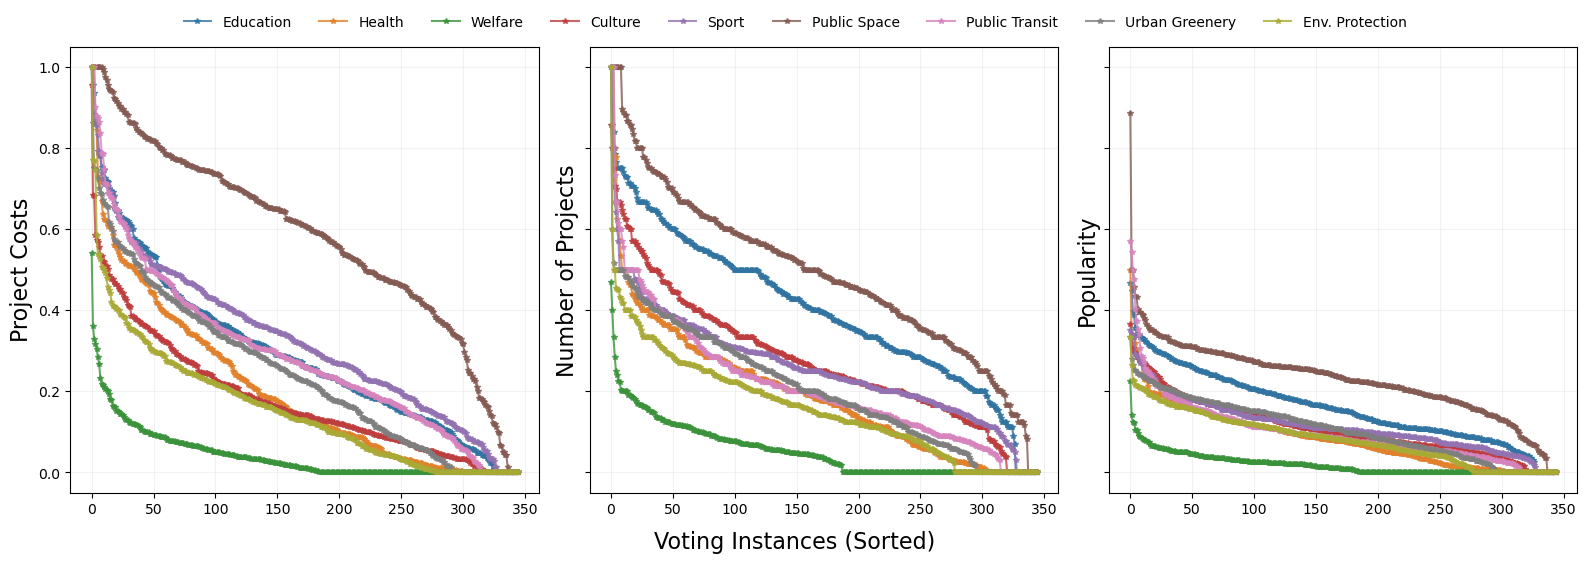

In [28]:
# plotting the cost share by categories
categories_color_map = {
    'education': '#d53e4f',
    'public_transit_and_roads': '#f46d43',
    'health': '#fdae61',
    'welfare': '#fee08b',
    'public_space': '#ffffbf',
    'urban_greenery': '#e6f598',
    'culture': '#abdda4',
    'sport': '#66c2a5',
    'env_protection': '#3288bd'
}

categories_color_map2 = {
    
    'education': '#3274a1',
    'public_transit_and_roads': '#d684bd',
    'health': '#e1812c',
    'welfare': '#3a923a',
    'public_space': '#845b53',
    'urban_greenery': '#7f7f7f',
    'culture': '#be3e3f',
    'sport': '#9372b2',
    'env_protection': '#a9aa35'
}

category_title_map = {
    'education': 'Education',
    'public_transit_and_roads': 'Public Transit',
    'health': 'Health',
    'welfare': 'Welfare',
    'public_space': 'Public Space',
    'urban_greenery': 'Urban Greenery', 
    'culture': 'Culture', 
    'sport': 'Sport',
    'env_protection': 'Env. Protection'
}

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=True, sharey=True)

for idx, category in enumerate(categories_set):
    temp_category_cost_df = impact_area_res[[f'{category}_project_cost_share']].sort_values(by=f'{category}_project_cost_share', ascending=False).reset_index()
    axes[0].plot(temp_category_cost_df[f'{category}_project_cost_share'], marker='*', markersize=4, label=category_title_map[f'{category}'], color=categories_color_map2[f'{category}'], alpha=0.8)

    temp_category_count_df = impact_area_res[[f'{category}_project_count_share']].sort_values(by=f'{category}_project_count_share', ascending=False).reset_index()
    axes[1].plot(temp_category_count_df[f'{category}_project_count_share'], marker='*', markersize=4, label=category_title_map[f'{category}'], color=categories_color_map2[f'{category}'], alpha=0.8)

    temp_category_popularity_df = impact_area_res[[f'{category}_popularity_share']].sort_values(by=f'{category}_popularity_share', ascending=False).reset_index()
    axes[2].plot(temp_category_popularity_df[f'{category}_popularity_share'], marker='*', markersize=4, label=category_title_map[f'{category}'], color=categories_color_map2[f'{category}'], alpha=0.8)

axes[0].set_ylabel('Project Costs', fontsize=16)
axes[0].grid(axis='both', which='major', color='gray', alpha=0.1)

axes[1].set_ylabel('Number of Projects', fontsize=16)
axes[1].grid(axis='both', which='major', color='gray', alpha=0.1)

axes[2].set_ylabel('Popularity', fontsize=16)
axes[2].grid(axis='both', which='major', color='gray', alpha=0.1)

# Customize legend
handles, labels = axes[0].get_legend_handles_labels()

# Create legend outside of the main plot
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.98), ncols=9, frameon=False, fontsize=10)

fig.text(0.5, -0.02, 'Voting Instances (Sorted)', fontsize=16, ha='center', va='center')

plt.tight_layout()
plt.show()

In [25]:
# combine the cost distribution and count distribution column across categories & melt into a single DF
cost_distribution_df = pd.DataFrame()
count_distribution_df = pd.DataFrame()
popularity_distribution_df = pd.DataFrame()

for idx, category in enumerate(categories_set):
    cost_category_df = impact_area_res[[f'{category}_project_cost_share']]
    count_category_df = impact_area_res[[f'{category}_project_count_share']]
    popularity_category_df = impact_area_res[[f'{category}_popularity_share']]
    
    cost_category_df['category'] = category_title_map[category]
    count_category_df['category'] = category_title_map[category]
    popularity_category_df['category'] = category_title_map[category]

    cost_distribution_df = pd.concat([cost_distribution_df, cost_category_df], ignore_index=True)
    count_distribution_df = pd.concat([count_distribution_df, count_category_df], ignore_index=True)
    popularity_distribution_df = pd.concat([popularity_distribution_df, popularity_category_df], ignore_index=True)

melted_cost_distribution_df = pd.melt(cost_distribution_df, id_vars=['category'], var_name='cat', value_name='cost_share')
melted_count_distribution_df = pd.melt(count_distribution_df, id_vars=['category'], var_name='cat', value_name='count_share')
melted_popularity_distribution_df = pd.melt(popularity_distribution_df, id_vars=['category'], var_name='cat', value_name='popularity_share')

melted_cost_distribution_df.dropna(inplace=True)
melted_count_distribution_df.dropna(inplace=True)
melted_popularity_distribution_df.dropna(inplace=True)

melted_count_distribution_df = melted_count_distribution_df.drop(['cat'], axis=1)
melted_cost_distribution_df = melted_cost_distribution_df.drop(['cat'], axis=1)
melted_popularity_distribution_df = melted_popularity_distribution_df.drop(['cat'], axis=1)

C:\Users\scsmah\AppData\Local\Temp\ipykernel_14340\461851403.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cost_category_df['category'] = category_title_map[category]
C:\Users\scsmah\AppData\Local\Temp\ipykernel_14340\461851403.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_category_df['category'] = category_title_map[category]
C:\Users\scsmah\AppData\Local\Temp\ipykernel_14340\461851403.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

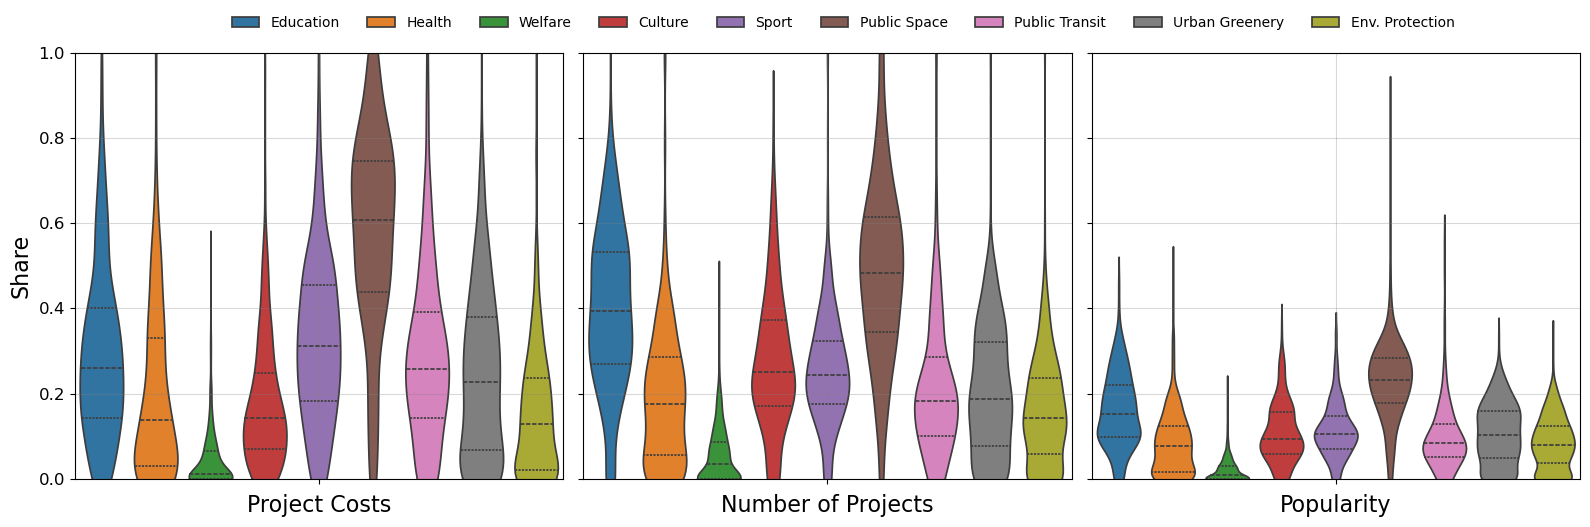

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

sns.violinplot(ax=axes[0], y='cost_share', hue='category', data=melted_cost_distribution_df, width=1, gap=0.2, saturation=0.75, inner="quart")
sns.violinplot(ax=axes[1], y='count_share', hue='category', data=melted_count_distribution_df, width=1, gap=0.2, saturation=0.75, inner="quart")
sns.violinplot(ax=axes[2], y='popularity_share', hue='category', data=melted_popularity_distribution_df, width=1, gap=0.2, saturation=0.75, inner="quart")

axes[0].set_ylabel('Share', fontsize=16)
axes[0].set_ylim([0,1])
axes[0].set_xlabel('Project Costs', fontsize=16)
axes[0].grid(axis='both', which='major', color='gray', alpha=0.3)

axes[1].set_xlabel('Number of Projects', fontsize=16)
axes[1].grid(axis='both', which='major', color='gray', alpha=0.3)

axes[2].set_xlabel('Popularity', fontsize=16)
axes[2].grid(axis='both', which='major', color='gray', alpha=0.3)

axes[0].legend().set_visible(False)
axes[1].legend().set_visible(False)
axes[2].legend().set_visible(False)

axes[0].tick_params(axis='y', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[2].tick_params(axis='y', labelsize=12)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.53, 0.98), ncols=9, frameon=False, fontsize=10)

plt.tight_layout()
plt.show()